In [1]:
import sys
import os

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm_notebook as tqn
%matplotlib inline

from copy import deepcopy
sys.path.append('..//..')

import meters as ms
from meters.batch import MeterBatch
from meters.batch.meter_batch import load_func

from meters.dataset import B,V,F,R,P, FilesIndex, Dataset, Pipeline
from meters.dataset.dataset.models.tf import ResNet18, DenseNet121, VGG19

plt.style.use('seaborn-poster')
plt.style.use('ggplot')

In [2]:
src_image = 'images_for_shuffle/'
src_data = 'new_data.csv'
# src_image = 'sorted_images/'
# src_data = 'vodokanal_data.csv'

In [3]:
src = src_image

fileindex = FilesIndex(path=src+'*.jpg', no_ext=True)

dset = Dataset(fileindex, batch_class=MeterBatch)
# dset.cv_split()

In [4]:
BATCH_SIZE = 25
NUM_DIGITS = 8
HEIGHT = 32
WIDTH = 16
VERTICALE_SCALE = 3.5
HORIZONTAL_SCALE = 1.5
NEW_SIZE = (int(VERTICALE_SCALE * HEIGHT), int(192 * HORIZONTAL_SCALE), 3)

In [5]:
def factor_sampler(size, p_square = 0.5):
    if np.random.binomial(1, p_square):
        return np.random.uniform(0.3, 1.7, (size,))
    return np.random.uniform(0.3, 1.7, (size,2))

def shift_sampler(size):
    return np.hstack((np.random.uniform(-60, 60, (size, 1)),\
                      np.random.uniform(-15, 10, (size, 1)),\
                      np.zeros((size, 1))))

def shape_sampler(size, crop_size=1):
    return np.random.randint(20, 50, (size, crop_size, 2))

def color_sampler(size, crop_size=1):
    return np.random.uniform(0, 1, (size, crop_size, 3))

def background_sampler(size, shape=(120, 120, 3), p_solid = 0.5):
    if np.random.binomial(1, p_solid):
        return np.ones((size, 120,120, 3))*color_sampler(size)[:, np.newaxis,...]
    return np.random.uniform(0, 1, (size,) + shape)

def random_origin_sampler(size, max_=3):
    return [['random'] * np.random.randint(0, max_) for _ in range(size)]
channels = np.array((0, 1, 2, (0, 1), (0, 2), (1, 2), (0, 1, 2)), dtype=object)
def channels_sampler(size):
    return channels[np.random.randint(len(channels), size=size)]

mode_generator=lambda size: np.random.choice(['constant', 'nearest', 'wrap'], size)

In [6]:
load_ppl = (
    Pipeline()
    .load_pil(src=src_image, components='images')
    .load(src=src_data, fmt='csv', components=['coordinates', 'labels'],
                  post=load_func, index_col='file_name')
    .generate_digit_cordinates()
    .enlarge_coordinates()
    .crop_from_bbox(dst='images')
    .update_digit_coordinates()
    .shuffle_digits(p=0.5,
                    src=['images', 'digit_coordinates', 'labels'], 
                    dst=['images', 'digit_coordinates', 'labels'])
    .skip_digits(n_workers=1)
    .assign_confidence(n_workers=1)
    .normalize_coordinates(image_src='images')
    .one_hot()
    .multiply(multiplier=1/255., preserve_type=False, 
              src='images',
              dst='new_images')
     .salt(size=lambda: np.random.randint(1, 10, 2),
           color=lambda: np.random.uniform(0, 1, 3),
           p_noise=P(R('uniform', 0.005, 0.01)), p=0.1, 
           src='new_images',
           dst='new_images')
     .posterize(colors_number=R('randint',8,254), p=0.5,
               src='new_images',
               dst='new_images')
     .invert(channels=P(R(channels_sampler)), p=0.3,
             src='new_images',
             dst='new_images')
     .multiplicative_noise(noise=lambda size: np.random.uniform(0.9, 1.1,size=size), p=0.9,
                           src='new_images',
                           dst='new_images')
    .additive_noise(noise=lambda size: np.random.normal(0, 0.01,size=size), p=0.9,
                    src='new_images',
                    dst='new_images')
    .gaussian_filter(sigma=P(R('uniform', 0.01, 1)), p=0.9,
                     src='new_images',
                     dst='new_images')
    .hommography_transform(p=0.7,
                     src=['new_images', 'digit_coordinates', 'labels'],
                     dst=['new_images', 'digit_coordinates', 'labels'])
#     .random_crop(p=0.5,
#                      src=['new_images', 'digit_coordinates'],
#                      dst=['new_images', 'digit_coordinates'])
    
#     .dump(dst='./shuffled_images/', ext='jpg', fmt='image', mode='w', components='images')
#     .dump(dst='shuffled_indices.csv', fmt='csv', mode='w', components='indices', header=False)
#     .dump(dst='shuffled_labels.csv', fmt='csv', mode='w', components='labels', header=False)
    ) << dset

In [30]:
BATCH_SIZE = 10
NUM_ITERS = 1
for i in tqn(range(NUM_ITERS)):
    tr = load_ppl.next_batch(BATCH_SIZE, n_epochs=None, suffle=True, drop_last=True)

C:\Users\Dari\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if issubdtype(ts, int):
C:\Users\Dari\Anaconda3\lib\site-packages\scipy\misc\pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [31]:
def unnorm(data, img_shape):
    data = data.reshape((-1, 4))
    data[:, 0] *= img_shape[0]
    data[:, 2] *= img_shape[0]
    data[:, 1] *= img_shape[1]
    data[:, 3] *= img_shape[1]
    return data

def plot_results(btch):
    index = np.random.randint(btch.data.new_images.shape[0])
    print('index', index)
#     index = 2
    print(btch.labels[index])
    img = btch.data.new_images[index]
    real = unnorm(deepcopy(btch.data.digit_coordinates[index]), img_shape=img.shape).astype(int)
#     print(btch.labels[index])
#     x, y, height, width = real[0, :]
#     img[x: x + height, y: y + width] = img[x - height: x, y: y + width][::-1, ::-1, :]
#     real = deepcopy(btch.data.digit_coordinates[index])
    fig,ax = plt.subplots(1)
    for i in range(8):
        x, y, height, width = real[i]
        if btch.data.confidence[index, i] == 0:
            true_rect = patches.Rectangle((y, x), width, height, linewidth=3, edgecolor='b', facecolor='none')
        else:
            true_rect = patches.Rectangle((y, x), width, height, linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(true_rect)
    ax.imshow(img)
    plt.show()


In [32]:
tr.indices[9]

'a03564'

index 3
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


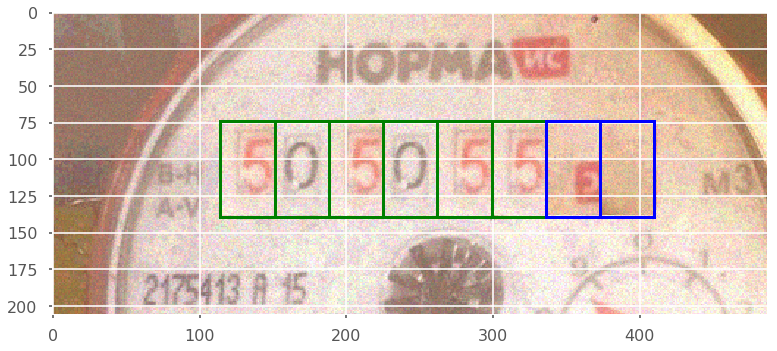

In [57]:
plot_results(tr)

In [111]:
for i in range(10):
    print(tr.images[i].shape)

(200, 456, 3)
(233, 524, 3)
(1409, 2490, 3)
(724, 1378, 3)
(798, 1540, 3)
(836, 1815, 3)
(551, 1241, 3)
(1030, 1655, 3)
(998, 2028, 3)
(1172, 2380, 3)


In [48]:
new_labels 

= np.eye(3)
new_labels[np.nonzero(new_labels)]

SyntaxError: invalid syntax (<ipython-input-48-f9b34dd897ec>, line 3)

In [14]:
(tr.confidence[5])

array([1., 1., 1., 1., 1., 1., 1., 1.])

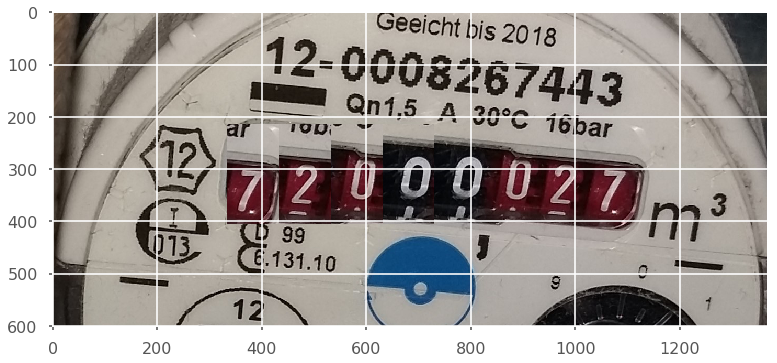

In [11]:
plt.imshow(tr.images[5])

In [8]:
a = np.arange(8)
a[np.nonzero(a)]

array([1, 2, 3, 4, 5, 6, 7])

In [9]:
to_skip =  np.random.randint(low=-3, high=3)
print(to_skip)
(8 + to_skip) % 8
        

-1


7

In [114]:
len_labels = 2
np.array([1] * len_labels + [0] * (8 - len_labels))

array([1, 1, 0, 0, 0, 0, 0, 0])

In [126]:
np.hstack((np.ones(len_labels), np.zeros(8 - len_labels)))

array([1., 1., 0., 0., 0., 0., 0., 0.])

In [181]:
# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f[:f.find('.')] for f in listdir('images_for_shuffle/') if isfile(join('images_for_shuffle', f))]

In [215]:
# j = 0
# for i, filename in enumerate(onlyfiles):
#     if filename in list(used_data['index']):
#         j += 1
#         print(filename)
#         os.remove('images_for_shuffle/' + filename + '.jpg')

In [16]:
import pandas as pd
from os import listdir
from os.path import isfile, join

In [102]:
def clean_folder():
    used_data = pd.read_csv('shuffled_indices.csv', names=['_', 'index'])
    onlyfiles = [f[:f.find('.')] for f in listdir('images_for_shuffle/') if isfile(join('images_for_shuffle', f))]
    j = 0
    for i, filename in enumerate(onlyfiles):
        if filename in list(used_data['index']):
            j += 1
#             print(filename)
            os.remove('images_for_shuffle/' + filename + '.jpg')
    print(j)

In [103]:
clean_folder()

500


In [92]:
def add_to_delete_list():
    onlyfiles = [f[:f.find('.')] for f in listdir('shuffled_images/') if isfile(join('shuffled_images', f))]
    used_data = pd.read_csv('shuffled_indices.csv', names=['_', 'index'])
    to_delete = set(used_data['index']) - set(onlyfiles)
    
    
    tdl = pd.read_csv('to_delete_for_shuffle.csv', names=['_', 'index'])
    tdl_new = list(to_delete) + list(tdl['index'])
    print(len(tdl_new))
    pd.Series(tdl_new).to_csv('to_delete_for_shuffle.csv')

In [93]:
add_to_delete_list()

26


In [110]:
def clean_folder():
    tdl = pd.read_csv('to_delete_for_shuffle.csv', names=['_', 'index'])
    onlyfiles = [f[:f.find('.')] for f in listdir('seen_images/') if isfile(join('seen_images/', f))]
    j = 0
    for i, filename in enumerate(onlyfiles):
        if filename in list(tdl['index']):
            j += 1
#             print(filename)
            os.remove('seen_images/' + filename + '.jpg')
    print(j)

In [112]:
clean_folder()

26


In [31]:
tr.labels[7]

array([1, 1, 1])

In [30]:
tr.confidence[7]

array([1., 1., 1., 0., 0., 0., 0., 0.])

In [13]:
def unnorm(data, img_shape):
    data = data.reshape((-1, 4))
    data[:, 0] *= img_shape[0]
    data[:, 2] *= img_shape[0]
    data[:, 1] *= img_shape[1]
    data[:, 3] *= img_shape[1]
    return data

def plot_results(btch):
    index = np.random.randint(btch.data.images.shape[0])
    print('index', index)
    index = 2
    print(btch.labels[index])
    img = btch.data.images[index]
    real = unnorm(deepcopy(btch.data.digit_coordinates[index]), img_shape=img.shape).astype(int)
#     print(btch.labels[index])
#     x, y, height, width = real[0, :]
#     img[x: x + height, y: y + width] = img[x - height: x, y: y + width][::-1, ::-1, :]
#     real = deepcopy(btch.data.digit_coordinates[index])
    fig,ax = plt.subplots(1)
    for i in range(8):
        x, y, height, width = real[i]
        if btch.data.confidence[index, i] == 0:
            true_rect = patches.Rectangle((y, x), width, height, linewidth=3, edgecolor='b', facecolor='none')
        else:
            true_rect = patches.Rectangle((y, x), width, height, linewidth=3, edgecolor='g', facecolor='none')
        ax.add_patch(true_rect)
    ax.imshow(img)
    plt.show()


index 0
[1 1 3]


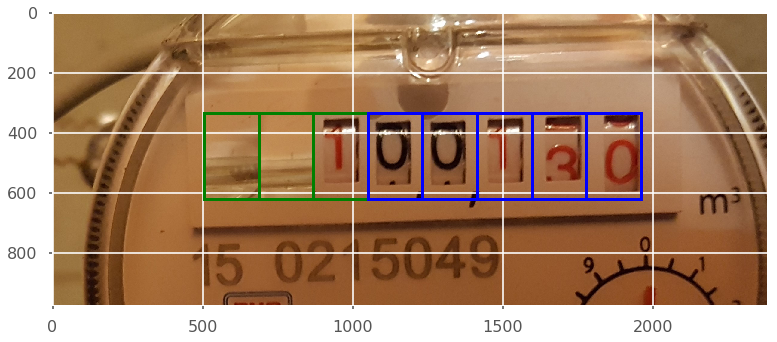

In [14]:
plot_results(tr)

In [17]:
a = np.arange(9)
a[a > 0]

array([1, 2, 3, 4, 5, 6, 7, 8])

In [11]:
from imageio import imsave, imread, imwrite

In [ ]:
img = tr.images[0]

In [ ]:
imsave('tmp.jpg', img)

In [27]:
img = imread('new_images/a04082.jpg')

In [28]:
img.shape

(326, 344, 4)

In [52]:
type(img)

imageio.core.util.Image

In [41]:
img[0,0,:].astype(np.int64)

Image([179, 139, 113, 255], dtype=int64)

In [29]:
img = np.array(img[:,:, :-1]).astype(np.int64)

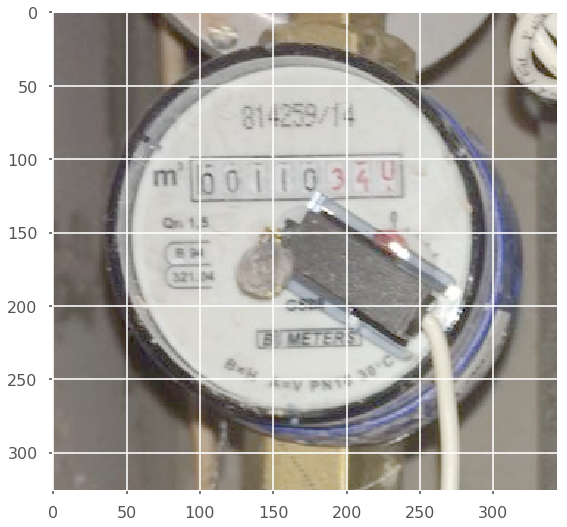

In [30]:
plt.imshow(img)

In [32]:
imwrite('images_for_shuffle/a04082.jpg', img)

C:\Users\Dari\Anaconda3\lib\site-packages\imageio\core\util.py:104: UserWarning: Conversion from int64 to uint8, range [0, 255]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))


In [26]:
a = os.listdir('./images_for_shuffle/')
for img in a:
    x = imread('./images_for_shuffle/'+img)
    if x.shape[-1] != 3:
        print(img)
#         x = x[:,:,:-1]
#         imwrite('./data/digits_new/'+img, x)

a04082.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


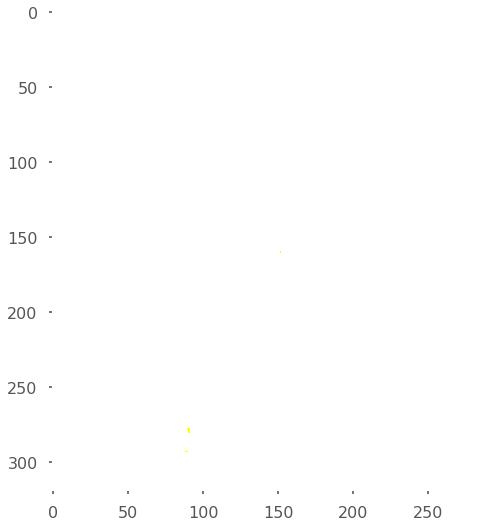

In [31]:
fig,ax = plt.subplots(1)
y, x, width, height = 517,531, 875,165
true_rect = patches.Rectangle((y, x), width, height, linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(true_rect)
ax.imshow(img)
plt.show()

In [32]:
np.random.choice(8, 8)

array([2, 6, 1, 2, 3, 0, 6, 5])

index 119
[4, 3, 7, 2, 2, 7, 3, 4]


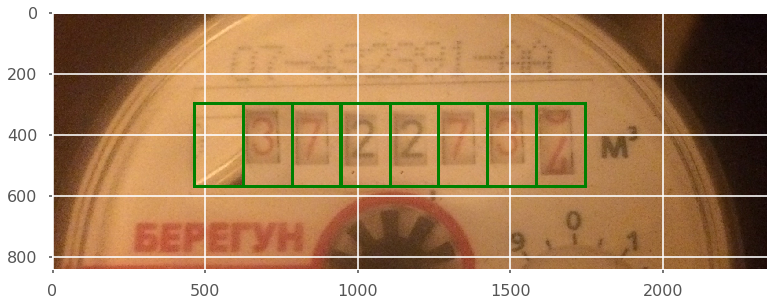

In [39]:
plot_results(tr)

index 207
[8, 5, 4, 7, 7, 4, 5, 8]


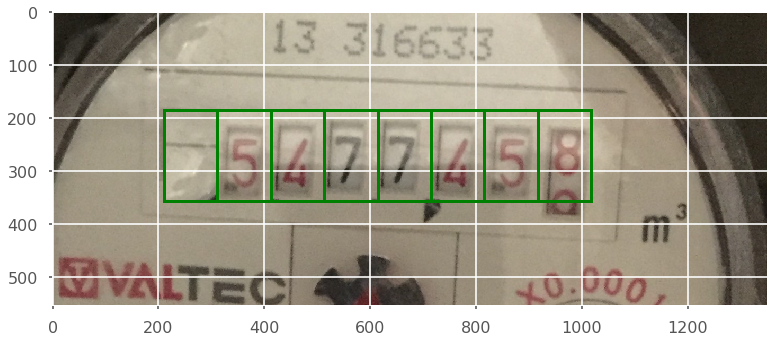

In [36]:
plot_results(tr)

In [45]:
tr.images[6].shape

(813, 1558, 3)

In [31]:
plot_results(tr)

index 161
[4, 1, 4, 5, 5, 4, 1, 4]


TypeError: slice indices must be integers or None or have an __index__ method